# Response time minimization - South-West police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.


#### South-West police district
South-West police district covers from 1 January 2020 23 municipalities in Rogaland, five municipalities in Vestland and one in Agder county. The police district stretched from Moi and Lund municipality in the south, to Bømlo and Fitjar in the north, and with the municipalities of Suldal and Sirdal in the east.

In [5]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-18T13:26:14.924802+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

matplotlib: 3.8.3
geopandas : 0.14.3
osmnx     : 1.9.1
numpy     : 1.26.4
pandas    : 2.2.1
pandana   : 0.7



## 0. Load road network

We load a road network of Oslo police district that has been preprocessed.
- Network type: drive
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633
- Network already contains edge weights (travel time in seconds)
- Node centrality measures has already been calculated for the network and stored as a CSV file.

In [7]:
### Load road network from file
SouthWest_filepath = "../data/SouthWest/SouthWestExtDriveImputed.graphml" # with travel time attribute
SouthWest_graph = ox.load_graphml(SouthWest_filepath) # originally in WGS84 (EPSG:4326)

In [45]:
SouthWest_graph = ox.projection.project_graph(SouthWest_graph, to_crs='EPSG:32633') # project to local UTM zone
print(f"Type of SouthWest_graph: {type(SouthWest_graph)}")
print(f"CRS of SouthWest_graph:  {SouthWest_graph.graph['crs']}")

# # # plot graph - obs combined graphs can straighten roads visually
# fig, ax = ox.plot_graph(SouthWest_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of SouthWest_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of SouthWest_graph:  EPSG:32633


Convert MultiDiGraph to node and edge GeoDataFrames.

In [9]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(SouthWest_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid   ref           name    highway maxspeed  \
u        v          key                                                       
60894741 676852078  0     53581260  4276      Mongveien  secondary       80   
         6498309502 0    692276023    44  Sokndalsveien    primary       80   

                         oneway reversed   length  \
u        v          key                             
60894741 676852078  0     False    False 1798.083   
         6498309502 0     False    False 1271.272   

                                                                  geometry  \
u        v          key                                                      
60894741 676852078  0    LINESTRING (-18787.259 6505430.688, -18791.170...   
         6498309502 0    LINESTRING (-18787.259 6505430.688, -18797.170...   

                         speed_kph  travel_time lanes bridge access tunnel  \
u        v          key                                                      
60894741 676852078  0       80.000       80.900   NaN    NaN    NaN    NaN   
         6498309502 0       80.000       57.200   NaN    NaN    NaN    NaN   

                        junction width est_width area service  
u        v          key                                        
60894741 676852078  0        NaN   NaN       NaN  NaN     NaN  
         6498309502 0        NaN   NaN       NaN  NaN     NaN

Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [10]:
# increase speed of edges
edges_increased = utilityModule.increase_edge_speeds(edges)
edges_increased.head(2) # verify increased edge speeds and shorter travel times

osmid   ref           name    highway maxspeed  \
u        v          key                                                       
60894741 676852078  0     53581260  4276      Mongveien  secondary       80   
         6498309502 0    692276023    44  Sokndalsveien    primary       80   

                         oneway reversed   length  \
u        v          key                             
60894741 676852078  0     False    False 1798.083   
         6498309502 0     False    False 1271.272   

                                                                  geometry  \
u        v          key                                                      
60894741 676852078  0    LINESTRING (-18787.259 6505430.688, -18791.170...   
         6498309502 0    LINESTRING (-18787.259 6505430.688, -18797.170...   

                         speed_kph  travel_time lanes bridge access tunnel  \
u        v          key                                                      
60894741 676852078  0      104.525       61.928   NaN    NaN    NaN    NaN   
         6498309502 0      104.525       43.784   NaN    NaN    NaN    NaN   

                        junction width est_width area service  
u        v          key                                        
60894741 676852078  0        NaN   NaN       NaN  NaN     NaN  
         6498309502 0        NaN   NaN       NaN  NaN     NaN

In [11]:
# recombining nodes and increased edges to MultiDiGraph format
SouthWest_graph_increased = ox.graph_from_gdfs(nodes, edges_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.
- Correct extent: Combined municipalities of  Asker, Bærum and Oslo.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [12]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
SouthWest_polygon_path = "../data/SouthWest/SouthWestCombinedPolygon.geojson"
SouthWest_polygon_gdf = gpd.read_file(SouthWest_polygon_path)
SouthWest_polygon_gdf = SouthWest_polygon_gdf.to_crs(SouthWest_graph.graph['crs']) # convert to same CRS as the road network

In [13]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/SouthWest/SouthWestPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(SouthWest_graph.graph['crs']) # convert to same CRS as the road network

In [14]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  19955006492000           2   
1  19955006492000           2   

                                            geometry  
0  POLYGON ((-4499.991 6492249.995, -4249.991 649...  
1  POLYGON ((-4499.991 6492249.995, -4249.991 649...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [15]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1000, max_range=1100) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=3600, max_range=3700) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 3682. Target range [3600, 3700], using population multiplier: 0.008347656250000002


id  population  \
7078  19685006573500         802   
7058  19695006572750         706   
7104  19690006573750         747   

                                               geometry  num_points  
7078  POLYGON ((-31499.982 6573499.992, -31499.982 6...           7  
7058  POLYGON ((-30499.983 6572749.992, -30499.983 6...           6  
7104  POLYGON ((-30999.982 6573749.992, -30999.982 6...           6

In [16]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

geometry
0  POINT (-9490.889 6498863.177)
1  POINT (-9843.277 6499788.124)
2  POINT (-9642.493 6499770.299)

In [17]:
# print number of nodes
print(f"Number of nodes: {len(nodes)}")

Number of nodes: 36574


In [18]:
# create polygons around high event density areas
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, 
                        density_threshold=2.0e-11, simplification_tolerance=5.0, plot_results=False)

Density: Min: 1.028e-27 | Median: 5.947e-12 | Mean: 6.584e-11 | Max: 2.193e-09


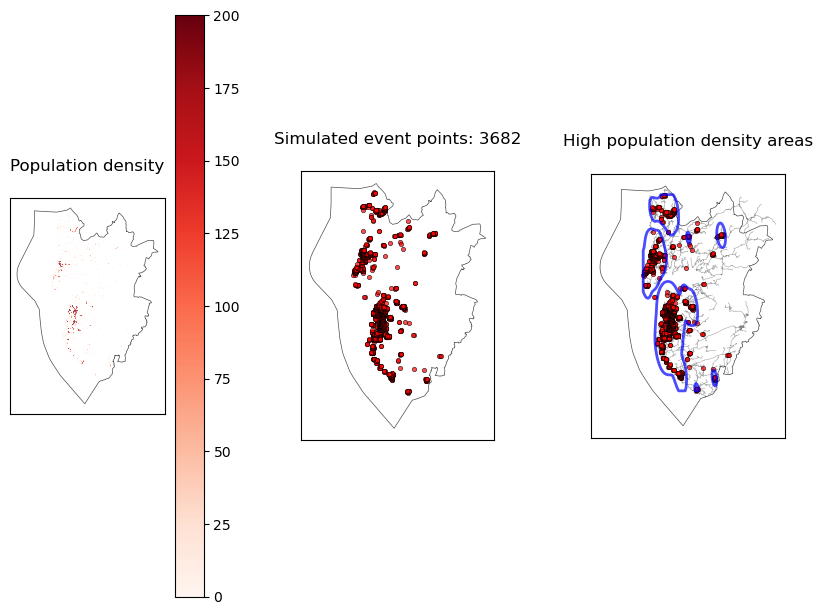

In [19]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(SouthWest_polygon_gdf, population_gdf, 
                                                       event_points_gdf, high_pop_density_area, edges)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [20]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/SouthWest/SouthWestNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count   lon    lat highway  ref  \
osmid                                                                      
60894741  6505430.688 -18787.259             3 6.113 58.380     NaN  NaN   
676852078 6503977.475 -19515.356             1 6.104 58.367     NaN  NaN   

                                 geometry  closeness_centrality  \
osmid                                                             
60894741   POINT (-18787.259 6505430.688)                 0.000   
676852078  POINT (-19515.356 6503977.475)                 0.000   

           betweenness_centrality  
osmid                              
60894741              2374003.000  
676852078                   0.000

### 2.2 Sample candidate points and filter out best candidate points

In [21]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 36574, nr of police car nodes: 100


y          x  street_count   lon    lat highway  ref  \
osmid                                                                       
1330645202 6623629.526 -49857.263             3 5.297 59.389     NaN  NaN   
5831535714 6626783.273 -39732.665             3 5.465 59.430     NaN  NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
1330645202  POINT (-49857.263 6623629.526)                 0.001   
5831535714  POINT (-39732.665 6626783.273)                 0.000   

            betweenness_centrality  
osmid                               
1330645202              919850.500  
5831535714               96194.000

Input nr of car nodes: 100
Remaining nr of car nodes: 85, after discarding the 15 (15%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


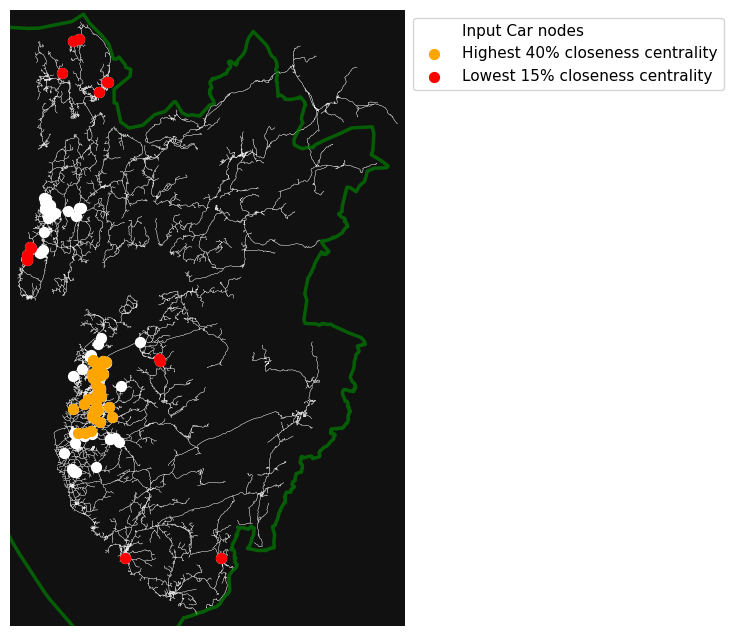

In [22]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=SouthWest_polygon_gdf, 
                    top_percent=0.4, bottom_percent=0.15, input_graph=SouthWest_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 85
Remaining nr of car nodes: 68, after discarding the 17 (20%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


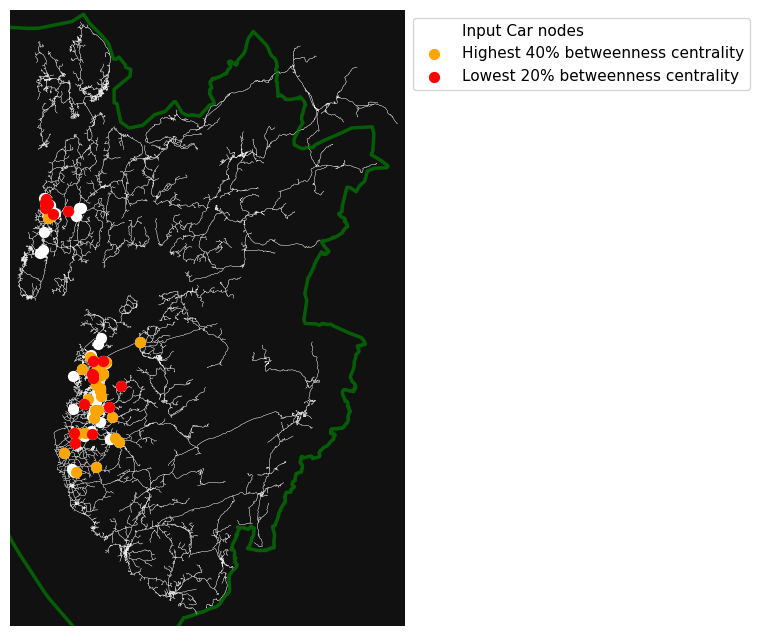

In [23]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=SouthWest_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.20, input_graph=SouthWest_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 68
Remaining nr of car nodes: 19, after removing the 49 nodes that are within 4000 m of each other



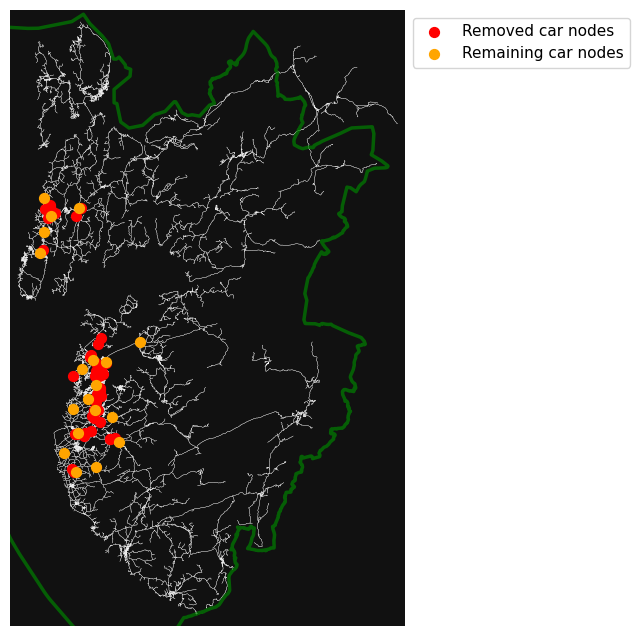

In [24]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=SouthWest_polygon_gdf, 
                             min_distance=4000, input_graph=SouthWest_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [25]:
# reset index so our origins and destinations are not in index
edges = edges_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed
# nodes = nodes.reset_index()

# create network with pandana
SouthWest_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of SouthWest_network_pdna: {type(SouthWest_network_pdna)}")
print(f"Network nodes:")
SouthWest_network_pdna.nodes_df.head(2)

type of SouthWest_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                           
60894741  -18787.259 6505430.688
676852078 -19515.356 6503977.475

In [26]:
print(f"Network edges: ")
SouthWest_network_pdna.edges_df.head(2)

Network edges: 


from          to   length  travel_time
0  60894741   676852078 1798.083       61.928
1  60894741  6498309502 1271.272       43.784

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.  
Therefore, we need to snap the event points to the Pandana network.

In [27]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = SouthWest_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry   nearest_node         x           y
0  POINT (-9490.889 6498863.177) 4896117247.000 -9604.389 6498851.297
1  POINT (-9843.277 6499788.124) 2810098526.000 -9858.391 6499744.491

In [28]:
# Get list of nearest node ids for event locations
event_nodes_pdna = SouthWest_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = SouthWest_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([7304181901,  668710250, 5288717553,  264562645,  705547114],
      dtype=int64)

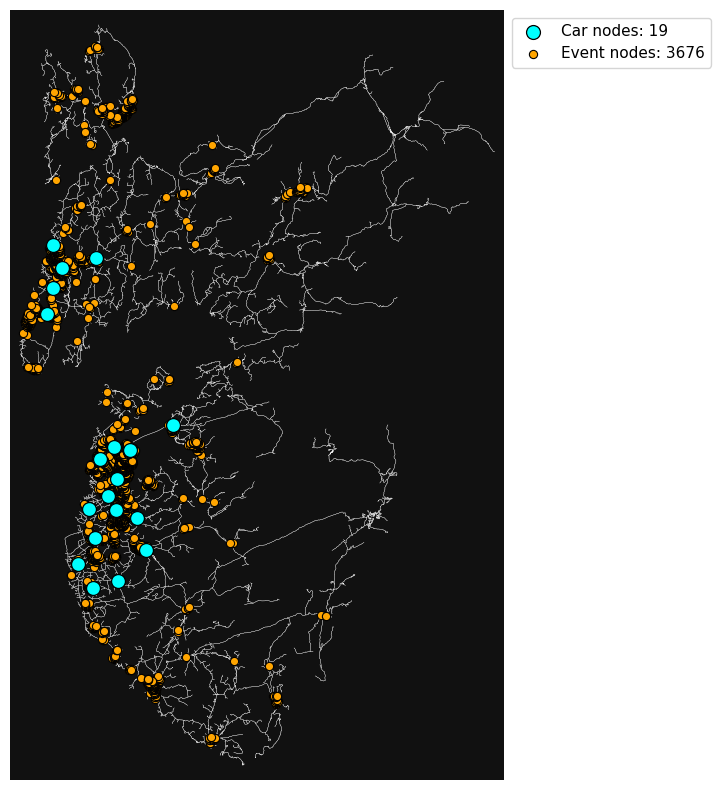

In [29]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(SouthWest_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [30]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [31]:
%%time
# travel time between each possible pair of car-event combination
distances = SouthWest_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = SouthWest_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')
print(f"{len(car_nodes_pdna)} origins x {len(event_nodes_pdna)} destinations = {len(origins)} origin-destination pairs (problem size)\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

c:\ProgramData\miniconda3\envs\MCLP_env\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(7304181901, 5638289858), (7304181901, 2837116420), (7304181901, 5831547922), (7304181901, 10313452243), (7304181901, 5831789402), (7304181901, 3283220499), (7304181901, 5838120653), (7304181901, 5838125665), (7304181901, 5838127137), (7304181901, 5838124158), (7304181901, 5838120283), (7304181901, 5838126218), (7304181901, 10789566374), (7304181901, 5838119737), (7304181901, 5838120493), (7304181901, 5838125857), (7304181901, 5838124032), (7304181901, 3255405628), (7304181901, 5838117753), (7304181901, 7399058417), (7304181901, 7399059015), (7304181901, 7399058412), (7304181901, 7399058429), (7304181901, 7399057676), (7304181901, 7399053289), (7304181901, 7399052358), (7304181901, 7399051672), (7304181901, 7399055532), (7304181901, 7399049689), (7304181901, 7

19 origins x 3676 destinations = 69844 origin-destination pairs (problem size)

5 first origin-destination distances [m]     : [69350.694, 69051.763, 68997.048, 68009.925, 68458.94]
5 first origin-destination travel times [sec]: [2597.498, 2590.554, 2604.157, 2505.173, 2550.197]
CPU times: total: 4.22 s
Wall time: 490 ms


In [32]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times) / 60 # in minutes
travel_times_df.describe().T

count      mean       std   min    25%    50%       75%       max
0 69844.000 27196.651 34732.734 0.000 12.987 26.406 71582.788 71582.788

In [33]:
# Restructure the distances and travel times arrays into a DataFrame (CSouthWest Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time   carNodeID  eventNodeID         x           y
0 69350.694     2597.498  7304181901   4896117247 -9604.389 6498851.297
1 69051.763     2590.554  7304181901   2810098526 -9858.391 6499744.491

In [34]:
# Save cost matrix to CSV
CostMatrix.to_csv("../data/SouthWest/SouthWestCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [35]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time   carNodeID   eventNodeID
0     2597.498  7304181901  4896117247_1
1     2590.554  7304181901  2810098526_1

In [36]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
margin = len(event_nodes_pdna) * 0.03 # 3% of all events
CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 1029 events per car
Filtering out 0% highest travel times - keeping only travel times <= 4294967 sec, or 71582.8 min
Original nr of pairs: 69844 | Filtered nr of pairs: 69844
Original max travel time: 4294967.295 | Filtered max travel time: 4294967.295


### 5.2 Setup LP problem

In [37]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 19
Number of events: 3676
Number of decision variables: 69863
Number of constraints: 73540
Number of non-zero coefficients: 69863
Number of non-zero coefficients in the objective function: 69841
CPU times: total: 2.66 s
Wall time: 3.65 s


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).

In [38]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
PULP_CBC_CMD with LP relaxation found 3/4 locations in 21.07 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 3219.23 seconds: [ 668710250  367125479  510615789 7474080167]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 2584502.0890 seconds, or 43075.03 minutes, or 717.92 hours
CPU times: total: 8.19 s
Wall time: 54min 8s


### 5.6 Extract results for inspection

In [39]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/SouthWest/SouthWestCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Optimal police car locations: dict_keys([668710250, 367125479, 510615789, 7474080167])
Car 668710250 is assigned 1029/1029 events
Car 367125479 is assigned 1029/1029 events
Car 510615789 is assigned 905/1029 events
Car 7474080167 is assigned 713/1029 events
Summing the events for each car gives 3676 events, which should equal the total number of unique events: 3676


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 19 | Optimal locations in solution: 4
- Events: 3676 | Max event capacity per police car: 1029

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 2584502 sec | 43075.0 min | 717.92 hours

Car id: 668710250 handles 1029 events | Capacity: 100.00% | Total response time: 6097.82 min | Median: 5.32 min | Avg: 5.93 min
Car id: 367125479 handles 1029 events | Capacity: 100.00% | Total response time: 7628.74 min | Median: 6.13 min | Avg: 7.41 min
Car id: 510615789 handles 905 events | Capacity: 87.95% | Total response time: 17246.83 min | Median: 11.24 min | Avg: 19.06 min
Car id: 7474080167 handles 713 events | Capacity: 69.29% | Total response time: 12101.63 min | Median: 13.81 min | Avg: 16.97 min


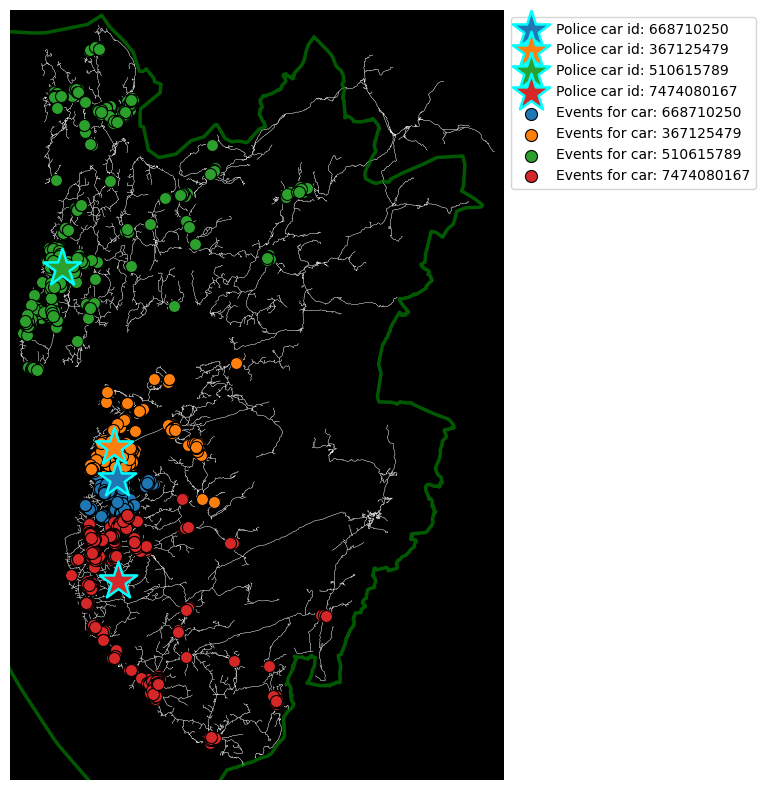

CPU times: total: 5.42 s
Wall time: 8.65 s


In [40]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(SouthWest_graph, SouthWest_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - reach in different time intervals
We visualize the collective reach of the police cars in the district with different time intervals.  
We plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [41]:
# Define how many trip times to visualize
TRIP_TIMES = [15, 40, 100]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [42]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(SouthWest_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=350, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 2min 13s
Wall time: 3min 24s


Isochrone polygons for the travel times: [15, 40, 100] minutes


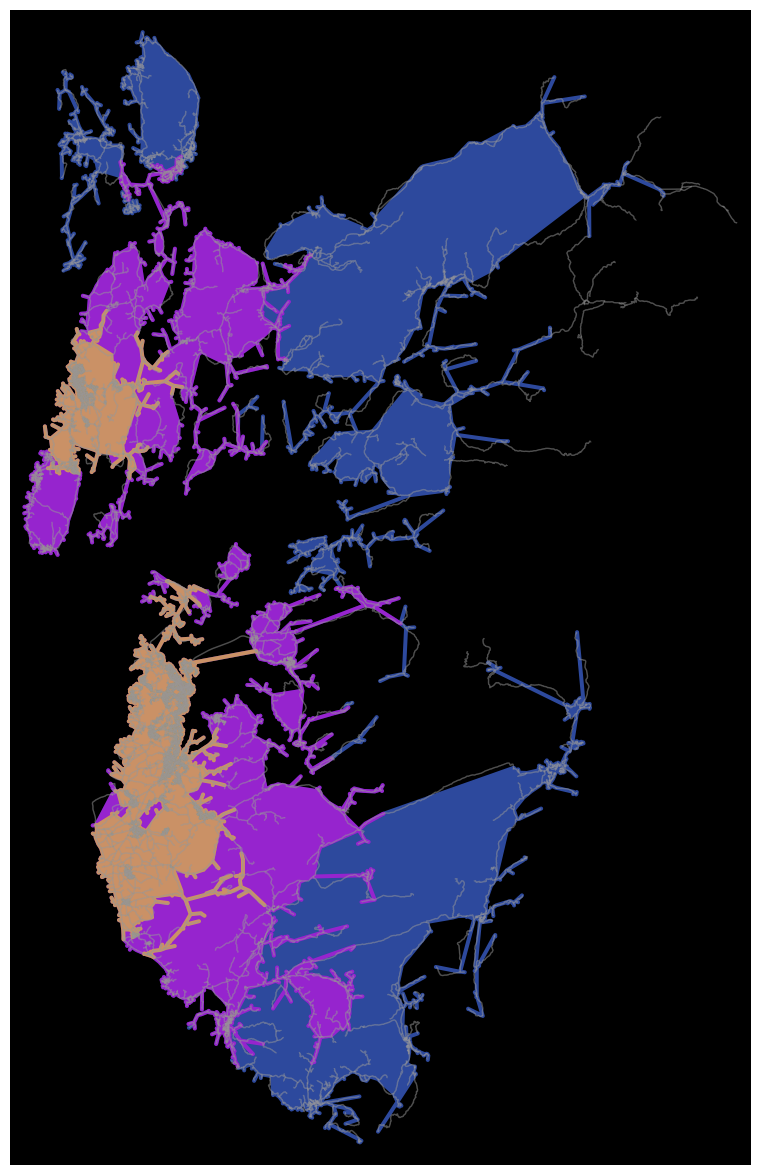

In [43]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(SouthWest_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [44]:
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(SouthWest_graph_increased, TRIP_TIMES, merged_isochrones, SouthWest_polygon_gdf, background_poly=True)
isochrone_map